# [phitar](https://jangcom.github.io/phitar/): Energy bin synchronization between tallies and cross sections

by J. Jang

* Last: 2020-06-06
* First: 2020-05-05

## Introduction

PHITS tally energy bins are expressed as pairs of e-lower and e-upper, whereas cross sections are expressed as functions of energy points. This resulted in slight differences between the energy bins of the two datasets until phitar v1.03. The two energy bins have now been synchronized in phitar v1.04; the method and testing results are presented in this notebook.

In [1]:
import re
import subprocess
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

In [2]:
# I/O
out_path = './out'  # Outbound
phits_path = '../phits'  # Inbound

# MPL
mpl.rcParams.update({'font.sans-serif': 'Arial',
                     'pdf.fonttype': 42})
plt.style.use('seaborn')

# IPython.display
set_matplotlib_formats('svg')

In [3]:
def save_curr_fig(out_bname, out_path=out_path):
    """Save a figure in multiple formats."""
    out_bname_full = '{}/{}'.format(out_path, out_bname)
    for fmt in ['pdf', 'svg']:
        plt.savefig('{}.{}'.format(out_bname_full, fmt), bbox_inches='tight')
    rtn = subprocess.run('inkscape {}.svg -M {}.emf'.format(out_bname_full, out_bname_full))

## Problem statement

Let's assume that the start end stop energies are 8 and 13 MeV, respectively, and the number of energy bins is 10. In phitar v1.03, the tally energy bins are interpolated as

In [4]:
# Data
np.random.seed(0)
e_start = 8
e_stop = 13
ne = (e_stop - e_start) * 2
xdata = np.linspace(e_start, e_stop, ne + 1)
ydata = np.random.uniform(low=0.00, high=0.2, size=ne)
ydata = np.append(ydata, None)  # Corresponds to ne + 1; for plotting only

df = pd.DataFrame({'e-lower': xdata[:-1],
                   'e-upper': xdata[1:],
                   'Random data': ydata[:-1]})
df

,e-lower,e-upper,Random data
0,8.0,8.5,0.109763
1,8.5,9.0,0.143038
2,9.0,9.5,0.120553
3,9.5,10.0,0.108977
4,10.0,10.5,0.084731
5,10.5,11.0,0.129179
6,11.0,11.5,0.0875174
7,11.5,12.0,0.178355
8,12.0,12.5,0.192733
9,12.5,13.0,0.0766883


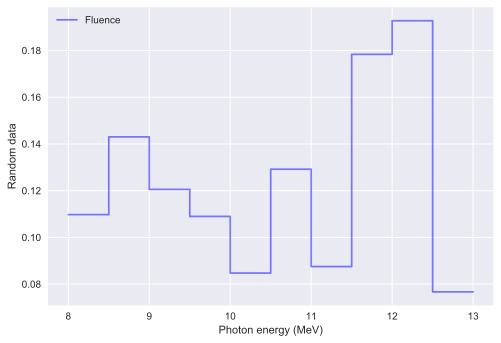

In [5]:
# Plot
plt.xlabel('Photon energy (MeV)')
plt.ylabel('Random data')
plt.step(xdata, ydata, 'b-', where='post', alpha=.5, label='Fluence')
plt.legend()

Note that PHITS tallies interpolate their fluence data for ne + 1, in which case the linear intervals between e-lower and e-upper are obtained as [(e_stop - e_start) / ne], not as [(e_stop - e_start) / (ne + 1)].

Now let's check the interpolation of cross sections.

In [6]:
# Data
np.random.seed(0)
ne = (e_stop - e_start) * 2
xdata2 = np.linspace(e_start, e_stop, ne)
ydata2 = np.random.uniform(low=0.00, high=0.2, size=ne)

df2 = pd.DataFrame({'e-point': xdata2,
                    'Random data': ydata2})
df2

,e-point,Random data
0,8.000000,0.109763
1,8.555556,0.143038
2,9.111111,0.120553
3,9.666667,0.108977
4,10.222222,0.084731
5,10.777778,0.129179
6,11.333333,0.087517
7,11.888889,0.178355
8,12.444444,0.192733
9,13.000000,0.076688


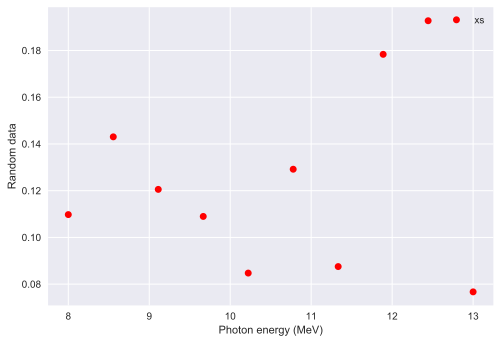

In [7]:
# Plot
plt.xlabel('Photon energy (MeV)')
plt.ylabel('Random data')
plt.plot(xdata2, ydata2, 'ro', label='xs')
plt.legend()

Plot the fluences and cross sections together:

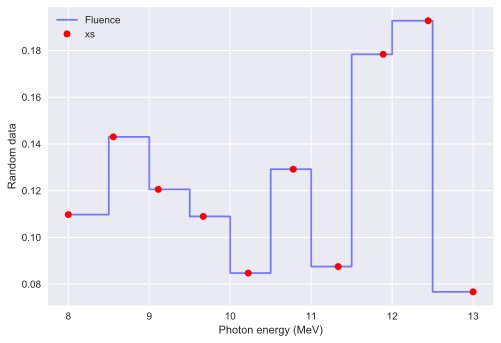

In [8]:
plt.xlabel('Photon energy (MeV)')
plt.ylabel('Random data')
plt.step(xdata, ydata, 'b-', where='post', alpha=.5, label='Fluence')
plt.plot(xdata2, ydata2, 'ro', label='xs')
plt.legend()

As suggested by the above plot, the array indices of the two data do not necessarily match, resulting in slight differences in the pointwise multiplication. Realizing this discrepancy, the author deciced to modify the interpolation of fluence data, while keeping the interpolation of cross sections intact.

## Solution

A simple solution is to make the midpoint of a tally energy bin equivalent to the energy point of a cross section. In this case, what we need to calculate are the e-lower of the first energy bin, or <em>e</em><sub>min</sub>, and the e-upper of the last energy bin, or <em>e</em><sub>max</sub>.

First, let's obtain <em>e</em><sub>min</sub>. By the above statement, it should hold that

In [9]:
%%latex

\[
  \frac{e_{\mathrm{lower}} + e_{\mathrm{upper}}}
       {2}
  =
  e_{\mathrm{point}}
\]

<IPython.core.display.Latex object>

A tally energy bin shows that <em>e</em><sub>upper</sub> is a function of <em>e</em><sub>lower</sub>, or vice versa:

In [10]:
df.head()

,e-lower,e-upper,Random data
0,8.0,8.5,0.109763
1,8.5,9.0,0.143038
2,9.0,9.5,0.120553
3,9.5,10.0,0.108977
4,10.0,10.5,0.084731


In [11]:
%%latex

\[
  e_{\mathrm{upper}} = e_{\mathrm{lower}} + \mathrm{d}e
\]

<IPython.core.display.Latex object>

We can therefore obtain

In [12]:
%%latex

\[
  \frac{2e_{\mathrm{lower}} + \mathrm{d}e}
       {2}
  =
  e_{\mathrm{point}}
\]

<IPython.core.display.Latex object>

Because we are trying to obtain <em>e</em><sub>min</sub>, it holds that <em>e</em><sub>lower</sub> = <em>e</em><sub>min</sub> and <em>e</em><sub>point</sub> = <em>e</em><sub>start</sub> (<em>e</em><sub>start</sub> is the start energy point of a cross section) and we obtain:

In [13]:
%%latex

\[
  \frac{2e_{\mathrm{min}} + \mathrm{d}e}
       {2}
  =
  e_{\mathrm{start}}
\]

<IPython.core.display.Latex object>

<em>e</em><sub>min</sub> is therefore

In [14]:
%%latex

\[
  e_{\mathrm{min}}
  =
  e_{\mathrm{start}}
  - 0.5 \mathrm{d}e
\]
of which d$e$ is
\[
  \mathrm{d}e
  =
  \frac{e_{\mathrm{stop}} - e_{\mathrm{start}}}
       {n_{\mathrm{e}} - 1}
\]
where $e_{\mathrm{stop}}$ is the highest source energy, and $n_{\mathrm{e}}$ is the number of energy bins assigned by the user.

<IPython.core.display.Latex object>

Now that we know d<em>e</em> and <em>e</em><sub>min</sub>, the corresponding <em>e</em><sub>max</sub> can be calculated as

In [15]:
%%latex

\[
  e_{\mathrm{max}}
  =
  e_{\mathrm{min}}
  + n_{\mathrm{e}} \mathrm{d}e
\]

<IPython.core.display.Latex object>

Note that the <em>n</em><sub>e</sub> should NOT be the typical linear spacing like:

In [16]:
%%latex

\[
  e_{\mathrm{max}}
  =
  e_{\mathrm{min}}
  + (n_{\mathrm{e}} - 1) \mathrm{d}e
\]
where the $-1$ is for $e_{\mathrm{min}}$.

This is because PHITS will interpolate the fluence data for $n_{\mathrm{e}} + 1$:

<IPython.core.display.Latex object>

Typical linear interpolation up to <em>n</em><sub>e</sub>
* (<em>n</em><sub>e</sub> - 1) required for <em>e</em><sub>min</sub> to become <em>e</em><sub>max</sub> ... (<em>n</em><sub>e</sub> - 1) + 1 = <em>n</em><sub>e</sub>

PHITS linear interpolation up to <em>n</em><sub>e</sub> + 1
* (<em>n</em><sub>e</sub>) required for <em>e</em><sub>min</sub> to become <em>e</em><sub>max</sub> ... (<em>n</em><sub>e</sub>) + 1 = <em>n</em><sub>e</sub> + 1

In phitar v1.04, the above solution has been implemented in a routine called determ_tally_emin_emax(). Now, let's try the solution.

In [17]:
# Fluence

# Read in the T-Track result file.
flue_f = '{}/flue.ang'.format(phits_path)
flue_fh = open(flue_f)
flue_lines = [v for v in flue_fh]
flue_fh.close()

# Retrieve only the data part and write them to a file.
data_rows = range(35, 46)
flue_data = [flue_lines[v] for v in data_rows]
flue_data[0] = re.sub('#(.*)', ' \\1', flue_data[0])
flue_trimmed_f = '{}/flue_trimmed.ang'.format(phits_path)
flue_trimmed_fh = open(flue_trimmed_f, 'w')
for line in flue_data:
    flue_trimmed_fh.write(line)
flue_trimmed_fh.close()

df3 = pd.read_csv(flue_trimmed_f, sep=r'\s+')

In [18]:
# xs
xs_f = '{}/xs.dat'.format(phits_path)
df4 = pd.read_csv(xs_f, sep=r'\s+', names=['e-point', 'Cross section', 'Interp'])
df4['e-point'] /= 1e6
df5 = pd.concat([df3.loc[:, ['e-lower', 'e-upper']], df4['e-point']], axis=1, sort=False)
df5

,e-lower,e-upper,e-point
0,7.8636,8.7201,8.29183
1,8.7201,9.5765,9.14829
2,9.5765,10.4330,10.00480
3,10.4330,11.2890,10.86120
4,11.2890,12.1460,11.71770
5,12.1460,13.0020,12.57410
6,13.0020,13.8590,13.43060
7,13.8590,14.7150,14.28710
8,14.7150,15.5720,15.14350
9,15.5720,16.4280,16.00000


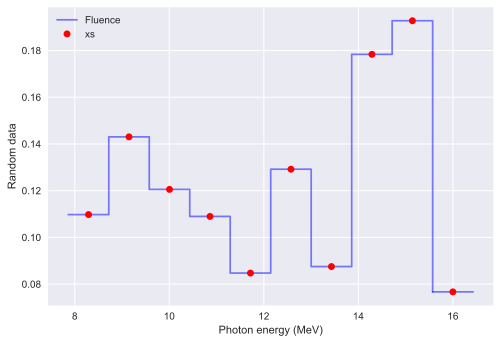

In [19]:
xdata3 = df5['e-lower']
xdata4 = df5['e-point']

df6 = df5.iloc[8:10, 1:2]
xdata5 = df6['e-upper']
ydata3 = np.array([ydata2[-1], None])

plt.xlabel('Photon energy (MeV)')
plt.ylabel('Random data')
plt.step(xdata3, ydata2, 'b-', where='post', alpha=.5, label='Fluence')
plt.step(xdata5, ydata3, 'b-', where='post', alpha=.5)
plt.plot(xdata4, ydata2, 'ro', label='xs')
plt.legend()

where the relation between the energy bins are clearly seen.

Compare phitar v1.03 and v1.04.

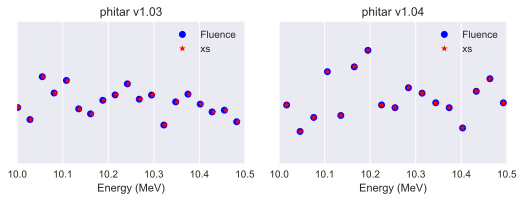

In [20]:
plt.figure(figsize=(7.5,3))

# PWM in phitar v1.03
pwm_f = '{}/pwm_v103.dat'.format(phits_path)
df7 = pd.read_csv(pwm_f, sep=r'\s+', header=None, comment='#')
xdata7 = df7.loc[:, 2]
ydata7 = df7.loc[:, 3]
xdata8 = df7.loc[:, 4]
ydata8 = df7.loc[:, 5]
plt.subplot(121)
plt.title('phitar v1.03')
plt.xlim(10, 10.5)
plt.xlabel('Energy (MeV)')
plt.yticks([])
plt.plot(xdata7, ydata7, 'bo', label='Fluence')
plt.plot(xdata8, ydata7, 'r*', label='xs')
plt.legend()

# PWM in phitar v1.04
pwm_f = '{}/pwm_v104.dat'.format(phits_path)
df7 = pd.read_csv(pwm_f, sep=r'\s+', header=None, comment='#')
xdata7 = df7.loc[:, 2]
ydata7 = df7.loc[:, 3]
xdata8 = df7.loc[:, 4]
ydata8 = df7.loc[:, 5]
plt.subplot(122)
plt.title('phitar v1.04')
plt.xlim(10, 10.5)
plt.xlabel('Energy (MeV)')
plt.yticks([])
plt.plot(xdata7, ydata7, 'bo', label='Fluence')
plt.plot(xdata8, ydata7, 'r*', label='xs')
plt.legend()
plt.tight_layout(pad=1.5)
save_curr_fig('phitar_v103_vs_v104')

where the fluence data were used as both fluence and cross section data for comparison purposes.

## Summary

* Until phitar v1.03, there have been discrepancies between the energy bins of PHITS fluences and cross sections.
* In phitar v1.04, the energy bin synchronization was carried out, as explained in this notebook.